In [ ]:
%load_ext autoreload
%autoreload 2
    
from multiprocessing import Pool
import os
from inspect import signature
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from nltk.tokenize import sent_tokenize, word_tokenize 

import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD

import seaborn as sns

sys.path.append("../src")
import constants as c
from utils import *

import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

In [590]:
plt.rcParams["figure.figsize"] = (20,10)

---

# Data
We're provided with 3 files. Train and test csv files and a submission example file for kaggle. The submission file is very simple, it includes 2 columns, one of a target ID, and one for the target prediction. The train/test datasets consist of 5 columns: an id, a keyword column that describes the type of disaster, a location of the tweet, the text body of the tweet, and finally, a target classifying it as real (target=1), or not (target=0). The training and test sets constain 7613 and 3263 examples, respectively.

In [600]:
train_df = load_data('train.csv')
test_df = load_data('test.csv') 
sample_submission_df = load_data('sample_submission.csv') 

In [611]:
tweets = df=pd.concat([train_df,test_df]).reset_index(drop=True)

In [612]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [613]:
print(f"train examples: {train_df.shape[0]}, test examples: {test_df.shape[0]}")

train examples: 7613, test examples: 3263


---

# Data analysis

### Distribution of tweet classes

In [614]:
n_real = tweets[tweets.target == 1].shape[0]
n_not_real = tweets[tweets.target == 0].shape[0]

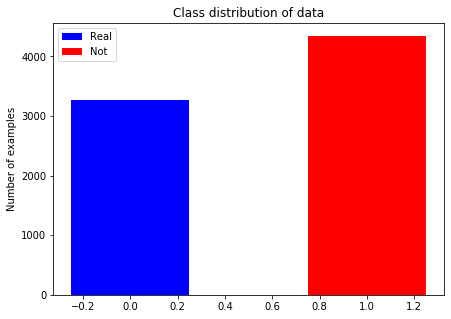

In [615]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(0,n_real,0.5, label="Real", color='blue')
plt.bar(1,n_not_real,0.5, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Class distribution of data')
plt.show()

### Distribution of number of characters in tweets

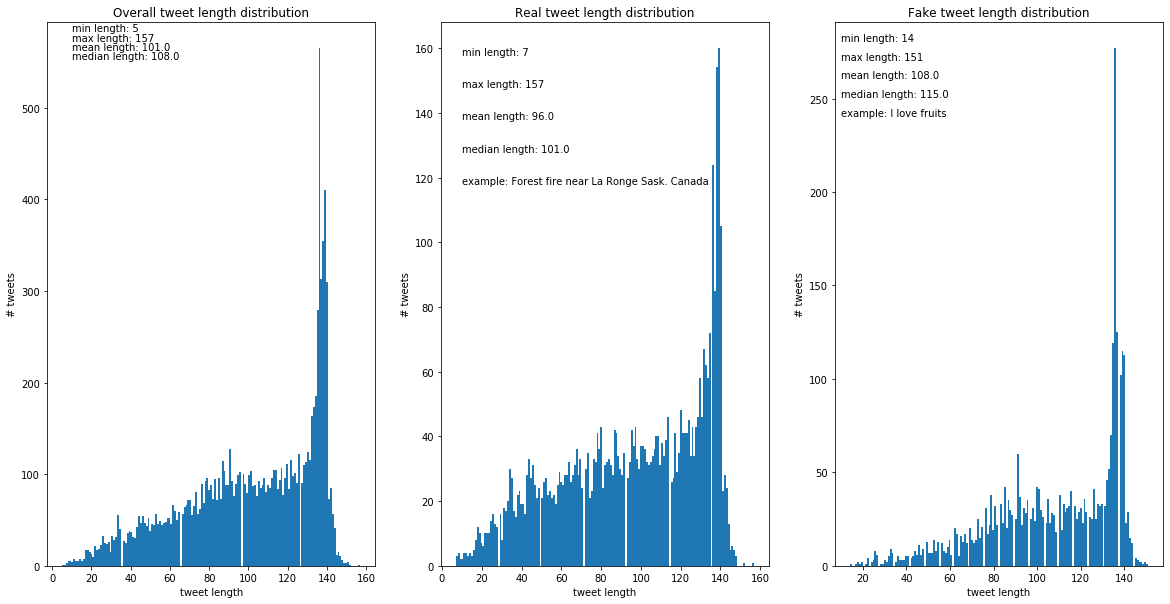

In [616]:
plt.rcParams["figure.figsize"] = (20,10)
plot_tweet_distribution(tweets)

### Distribution of number of words in tweets

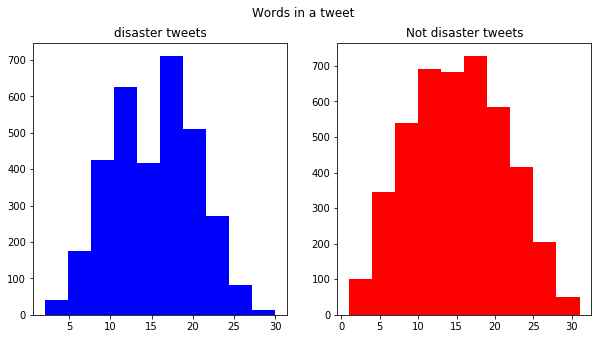

In [617]:
word_length_distribution(tweets)

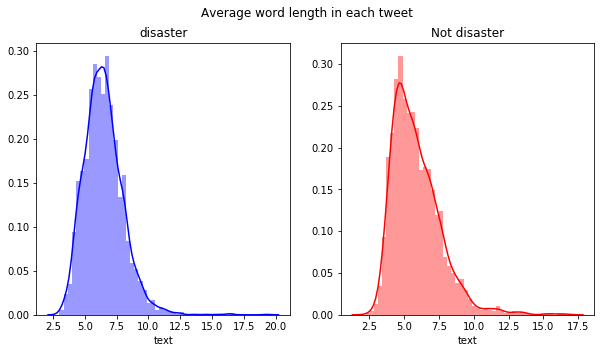

In [754]:
average_word_length_distribution(tweets)

### Most frequent keywords

#### Disaster tweets

/Volumes/mac/Luis/learning/kaggle/nlp - twitter/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


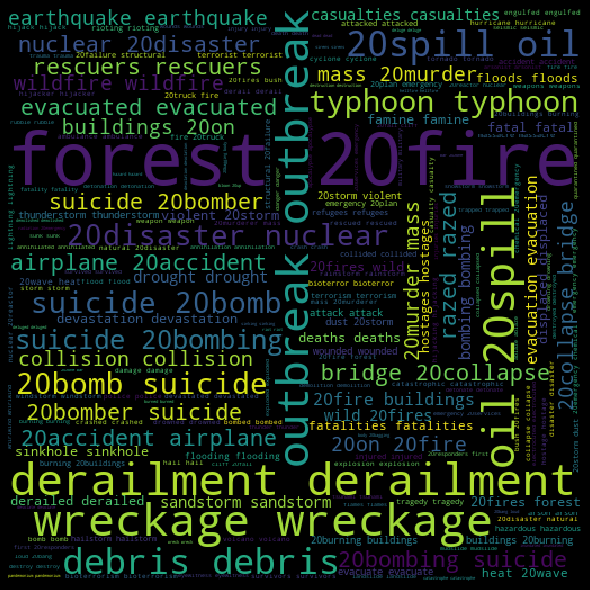

In [619]:
corpus = train_df[(tweets["keyword"].isna() == False) & (tweets["target"] == 1) ]["keyword"].values
word_cloud(corpus)

#### Non Disaster tweets

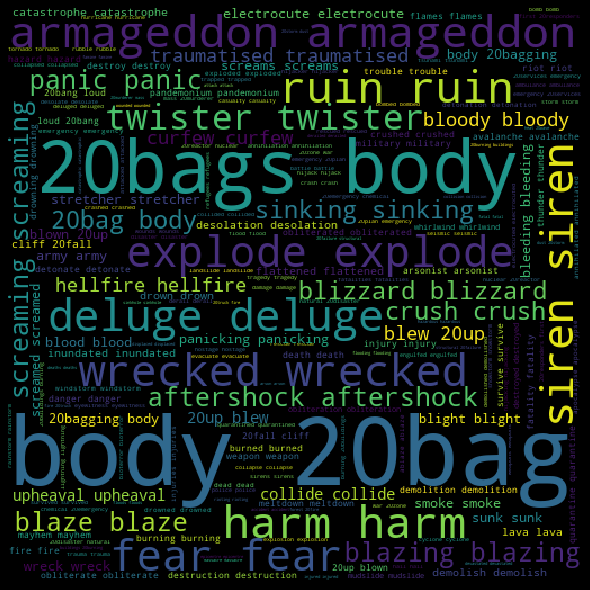

In [620]:
corpus = train_df[(train_df["keyword"].isna() == False) & (train_df["target"] == 0) ]["keyword"].values
word_cloud(corpus)

### Most frequent words in text

In [621]:
tweets_1 = tweets[tweets['target']==1]["text"].values
tweets_0 = tweets[tweets['target']==0]["text"].values
corpus_0 = make_corpus(tweets_1)  # non-real disaster tweet
corpus_1 = make_corpus(tweets_0)  # real disaster tweet

### Non-disaster tweets

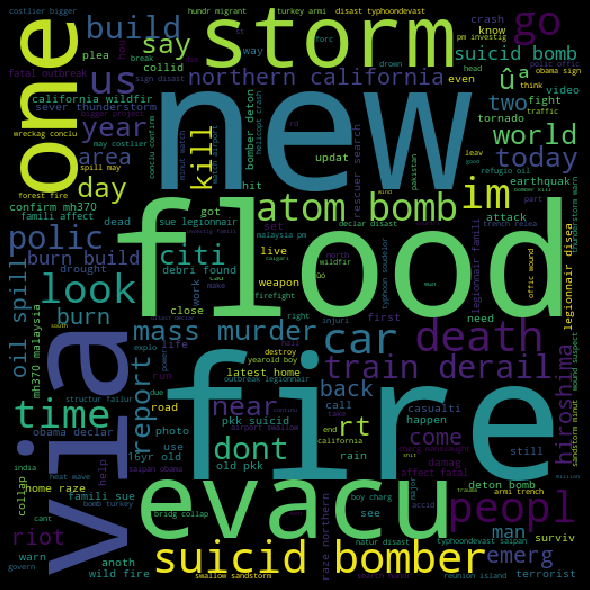

In [622]:
word_cloud(make_corpus(corpus_0))

### Disaster tweets

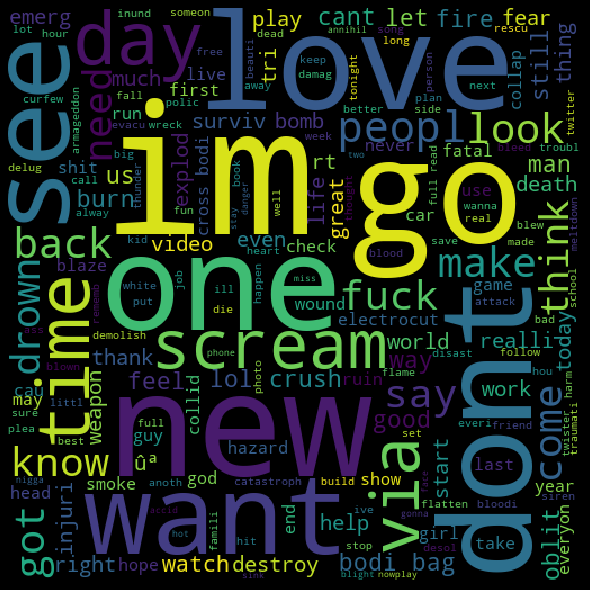

In [623]:
word_cloud(make_corpus(corpus_1))

### Distribution of punctuation

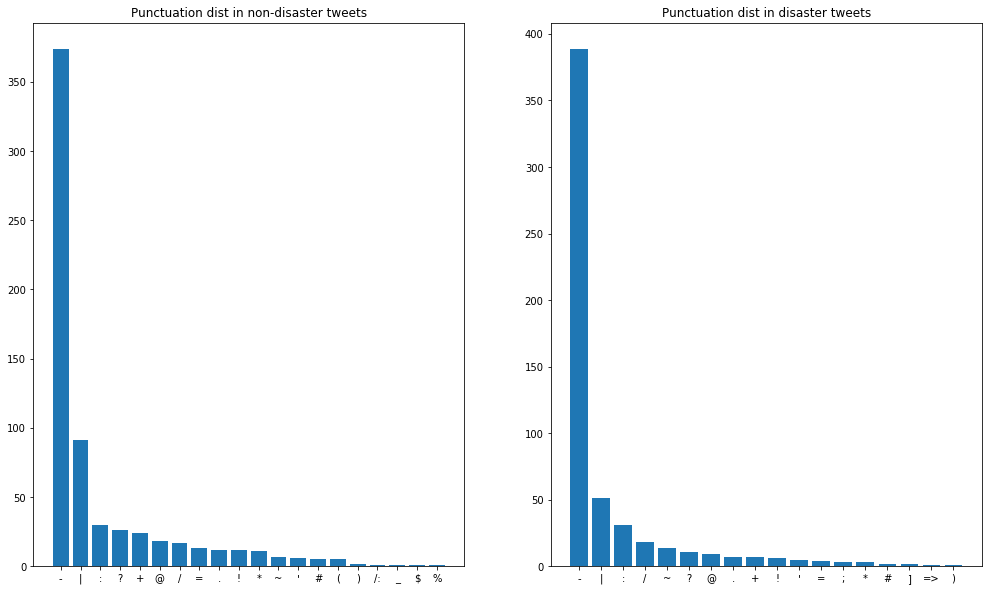

In [624]:
punctuation_dist(tweet)

### Most common bigrams

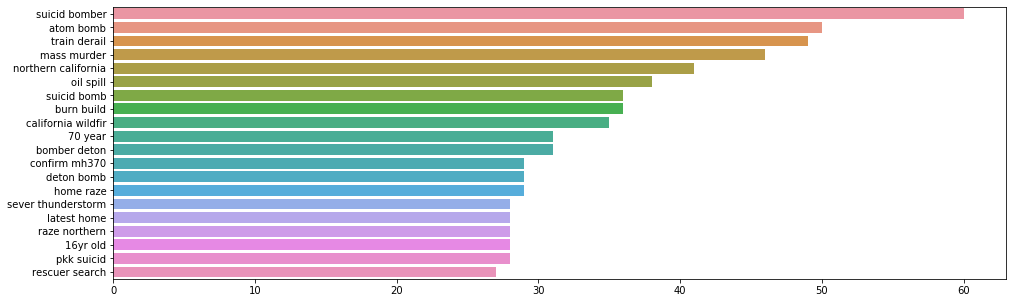

In [625]:
# Non disaster tweets
plot_bigrams(corpus_0)

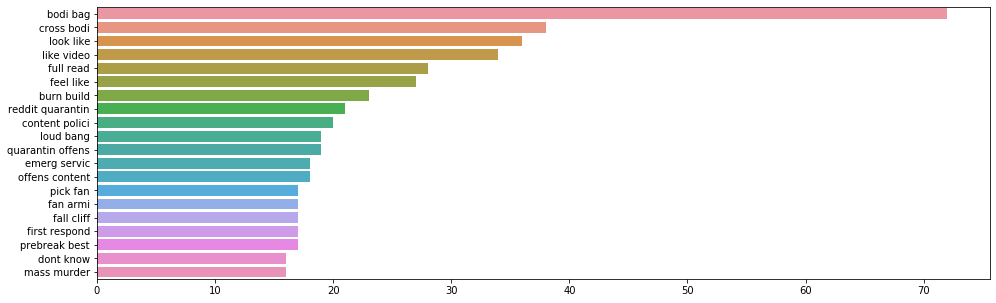

In [626]:
# Disaster tweets
plot_bigrams(corpus_1)

---

# Tweet representation for Machine Learning models

Machine learning models use numeric data, hence we can't feed the model actual words. Similarly to how we'd pre-process categorical data for any other model (e.g. a decision tree or linear regression) to one-hot encode the data, we will need to find a numeric representation for our tweets. For language models, that representation takes the form of vectors.

#### Bag of words
The most basic vector representation of language is a bag of words. This is a simple representation of the frequency of the words

#### TF-IDF (term frequency-inverse document frequency) 
TF-IDF assigns importance to words based on the frequency in specific documents (a word is more important if it's frequent in a document, but rare in all the documents)



#### Word2vec
This representation, also knows as word embeddings, find similarity and analog between words. The vectors are the output of a shallow (2-layers) neural network trained on the co-occurrence of word, that is, it finds word contexts. One can use distance measures in the vector space representation to find analogies, e.g. Given that King is to Queen, or is Man to... We'll find Man is to Woman. Or Paris is to France as Beijing is to... China.

#### Glove
The Glove model was an improvement over word2vec. This model uses a matrix of frequency and matrix factorization algorithm to find the vector

### Visualization of the different word representation

First, lets split our training set into a train and test (validation) set

In [691]:
corpus = make_corpus(train_df["text"].values)

In [693]:
X_train, X_test, y_train, y_test = train_test_split(corpus, train_df["target"].tolist(), test_size=0.2,random_state=42)

We humans can only visualuze things in 2 or 3 dimentions. Therefore we'll have to reduce the dimentions of the vector representations to 2 or 3. A popular dimentionality reduction method for visualization purpose is [t-SNE](https://towardsdatascience.com/t-sne-python-example-1ded9953f26). Anothers options are [LSA and LDA](https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547). LSA is based on SVD and tries to maximize the variance, while t-SNE created a reduced feature space where similar samples are modeled by nearby points and dissimilar samples are modeled by distant points with high probability. At a high level, t-SNE constructs a probability distribution for the high-dimensional samples in such a way that similar samples have a high likelihood of being picked while dissimilar points have an extremely small likelihood of being picked. Then, t-SNE defines a similar distribution for the points in the low-dimensional embedding. Finally, t-SNE minimizes the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the embedding.

before word embeddings, LSA and LDA were two popular methods for NLP problems. LSA finds a reduced representation of the word vectors, while LDA find topics in documents based on co-occurrence of words. LSA is based on SVD matrix decomposition, and we'll use it to reduce the dimentions of the word vectors to 2 so we can plot it. The idea of SVD is finding the most valuable information and using lower dimension t to represent same thing.






### Bag of Words

In [694]:
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english', lowercase=True)

In [695]:
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

X_train_embeddings, the vector representation, is a sparse matrix. We can convert it to a dense matrix to visualize it. Each row is a vector representation of a tweet.


In [696]:
X_train_counts[:10].todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [697]:
print('Bag of words output shape:', X_train_counts.shape)

Bag of words output shape: (6090, 10512)


In [698]:
len(X_train)

6090

We can see that we have the same number of tweets (6090), and each tweet is represented by a vector of size 10512

In [699]:
svd = TruncatedSVD(n_components=2)

In [700]:
x_train_svd = svd.fit_transform(X_train_counts)
x_test_svd = svd.transform(X_test_counts)

In [701]:
print('LSA output shape:', x_train_svd.shape)

LSA output shape: (6090, 2)


Notice how we still have a vector representation of 6090 tweets, but each is only represented by a vector of size 2

In [702]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))

Sum of explained variance ratio: 1%


Notice how our representation of size 2 only explains 1% of the variance. That would be a terrible model.

#### Sidetrack: could we use this reduced representation to train a model to classify the tweets?

In [703]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
lr_model = LogisticRegression(solver='newton-cg',n_jobs=-1)
lr_model.fit(x_train_svd, y_train)
cv = KFold(n_splits=5, shuffle=True)
    
scores = cross_val_score(lr_model, x_test_svd, y_test, cv=cv, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.6559 (+/- 0.0695)


It is amazing that by using this size 2 representation we can still classify the tweet with 66% accuracy. Of course we could include a higher number of dimentions to get a better accuracy, but we digress. We want just 2 dimentions to visualize the data, and we''ll use a different type of model for our training

#### Another quick detour
We've used LSA/SVD to reduce the dimentions of the tweet vector representation. Since LDA is a related concept, let's take a quick detour to see how it applies.

LDA finds topics in our document's corpus, and the words relevant to those topics (we have to pick the number of topics in advance, though).


In [733]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
def build_lda(x_train, num_of_topic=10):
    vec = CountVectorizer()
    transformed_x_train = vec.fit_transform(x_train)
    feature_names = vec.get_feature_names()
    lda = LatentDirichletAllocation(
        n_components=10, max_iter=5, 
        learning_method='online', random_state=0)
    lda.fit(transformed_x_train)
    return lda, vec, feature_names
def display_word_distribution(model, feature_names, n_word):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-n_word - 1:-1]:
            words.append(feature_names[i])
        print(words)
lda_model, vec, feature_names = build_lda(X_train)
display_word_distribution(
    model=lda_model, feature_names=feature_names, 
    n_word=5)

Topic 0:
['one', 'disast', 'bodi', 'bag', 'video']
Topic 1:
['news', 'still', 'via', 'death', 'ûª']
Topic 2:
['emerg', 'storm', 'fear', 'accid', 'plan']
Topic 3:
['bomb', 'say', 'look', 'new', 'back']
Topic 4:
['world', 'caus', 'fatal', 'last', 'nuclear']
Topic 5:
['like', 'im', 'get', 'dont', 'day']
Topic 6:
['fire', 'evacu', 'california', 'news', 'mani']
Topic 7:
['would', 'derail', 'train', 'today', 'collid']
Topic 8:
['build', 'burn', 'come', 'crash', 'collaps']
Topic 9:
['kill', 'go', 'attack', 'polic', 'drown']


##### And finally, let's see a visualization of our bag of words representation

### t-SNE

In [707]:
X_embedded = TSNE(n_components=2).fit_transform(X_train_counts)

In [708]:
X_embedded.shape

(6090, 2)

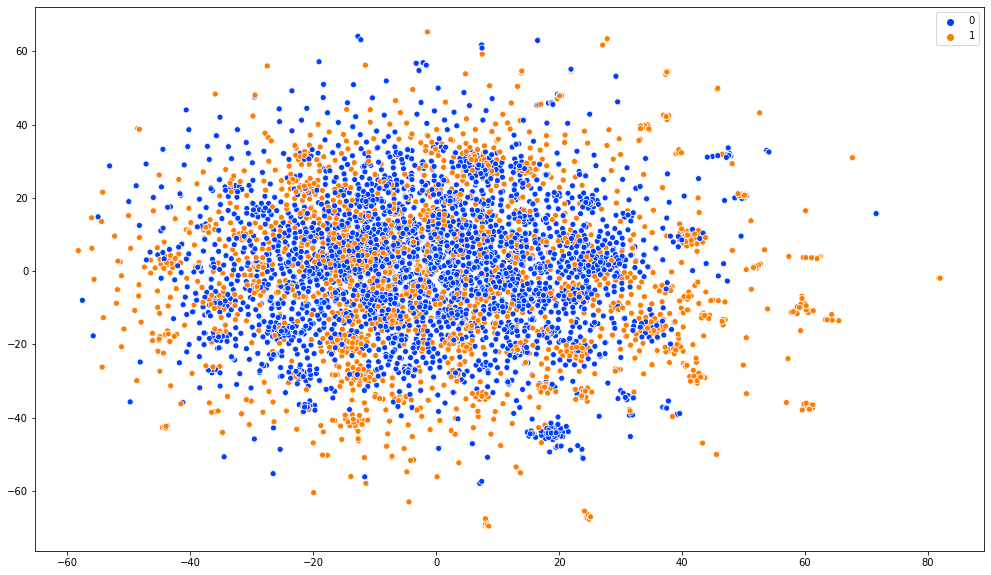

In [734]:
palette = sns.color_palette("bright", 2)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_train, legend='full', palette=palette)
plt.show()

### LSA

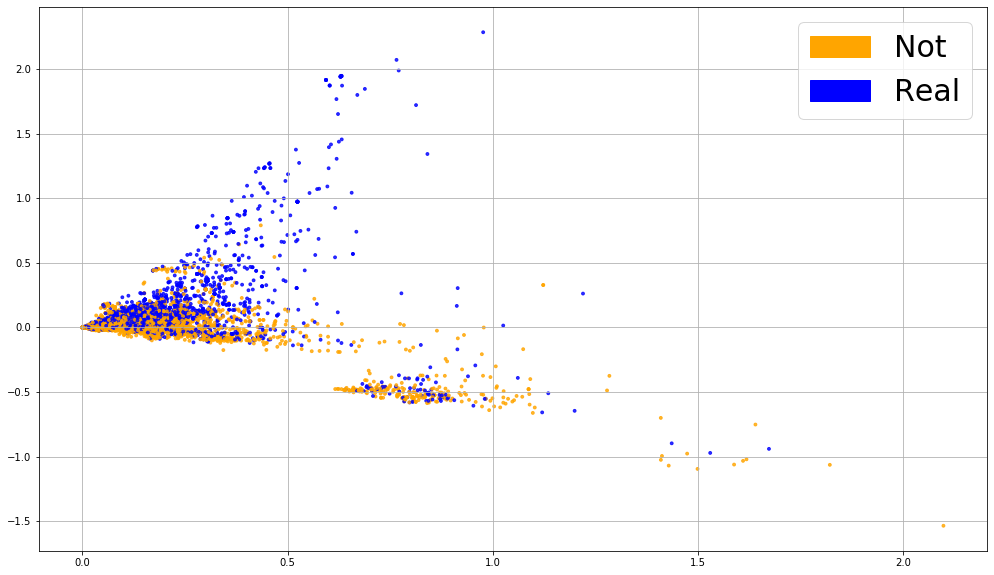

In [755]:
color_mapper = {label:idx for idx,label in enumerate(set(y_train))}
color_column = [color_mapper[label] for label in y_train]
colors = ['orange','blue']

plt.scatter(x_train_svd[:,0], x_train_svd[:,1], s=8, alpha=.8, c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
orange_patch = mpatches.Patch(color='orange', label='Not')
blue_patch = mpatches.Patch(color='blue', label='Real')
plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})
plt.grid(True)
plt.show()

**These embeddings don't have a clear separation. We'll compare it to other embeddings, and the performance of each resulting model**

### TF-IDF

scikit provides both TfidfTransformer and TfidfVectorizer. TfidfTransformer needs counterVectorizer to compute the word counts and then does TF and IDF.  TfidfVectorizer does all in one. I'll use TfidfTransformer here just so to demonstrate the use of pipelines.

In [757]:
tfidf_vectorizer = TfidfTransformer()

In [765]:
pipeline = Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(stop_words='english', lowercase=True)),
    ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True))
])

In [788]:
train = pipeline.fit_transform(X_train, y_train)
test = pipeline.transform(X_test)

# # using TfidfVectorizer:
# tfidf_vectorizer = TfidfVectorizer()
# train = tfidf_vectorizer.fit_transform(X_train)
# test = tfidf_vectorizer.transform(X_test)

In [789]:
# SVD on the TF-IDF encoding
x_train_svd = svd.fit_transform(train)
x_test_svd = svd.transform(test)

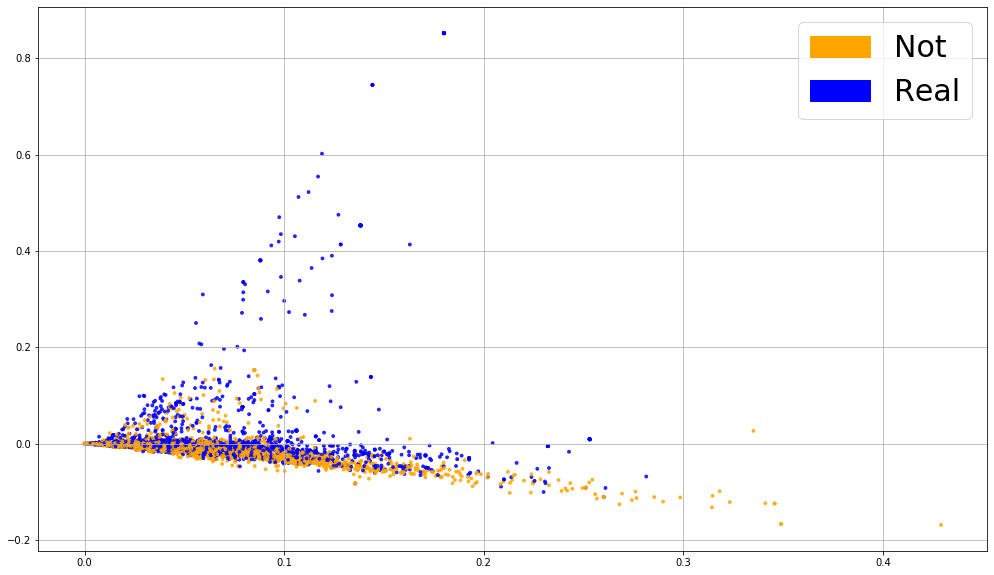

In [790]:
color_mapper = {label:idx for idx,label in enumerate(set(y_train))}
color_column = [color_mapper[label] for label in y_train]
colors = ['orange','blue']

plt.scatter(x_train_svd[:,0], x_train_svd[:,1], s=8, alpha=.8, c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
orange_patch = mpatches.Patch(color='orange', label='Not')
blue_patch = mpatches.Patch(color='blue', label='Real')
plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})
plt.grid(True)
plt.show()

**Similarly to the bag of words, this representation also does not separate too well the two classes**

### Word2Vec

In [ ]:
data = [] 
for sentence in X_train:
    data.append(word_tokenize(sentence))

In [815]:
# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count = 1,  
                              size = 100, window = 5) 

In [813]:
# Create Skip Gram model 
model2 = gensim.models.Word2Vec(data, min_count = 1, size = 100, window = 5, sg = 1) 
  

In [827]:
model1.similarity('storm', 'train')

0.9941996

In [829]:
model1.most_similar('storm')

[('get', 0.9974590539932251),
 ('fire', 0.9973517656326294),
 ('go', 0.9971781969070435),
 ('flood', 0.9971569776535034),
 ('one', 0.9971345663070679),
 ('peopl', 0.9971247911453247),
 ('like', 0.9970871806144714),
 ('day', 0.9970806241035461),
 ('dont', 0.9969812035560608),
 ('im', 0.9969062805175781)]

In [830]:
model1.most_similar('fire')

[('get', 0.9986522197723389),
 ('go', 0.9985184073448181),
 ('2', 0.9984985589981079),
 ('like', 0.9984477758407593),
 ('flood', 0.9983986020088196),
 ('im', 0.9983921051025391),
 ('peopl', 0.9983647465705872),
 ('time', 0.9983033537864685),
 ('emerg', 0.9982455968856812),
 ('new', 0.9981520175933838)]

### Visualize the embedding

In [824]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

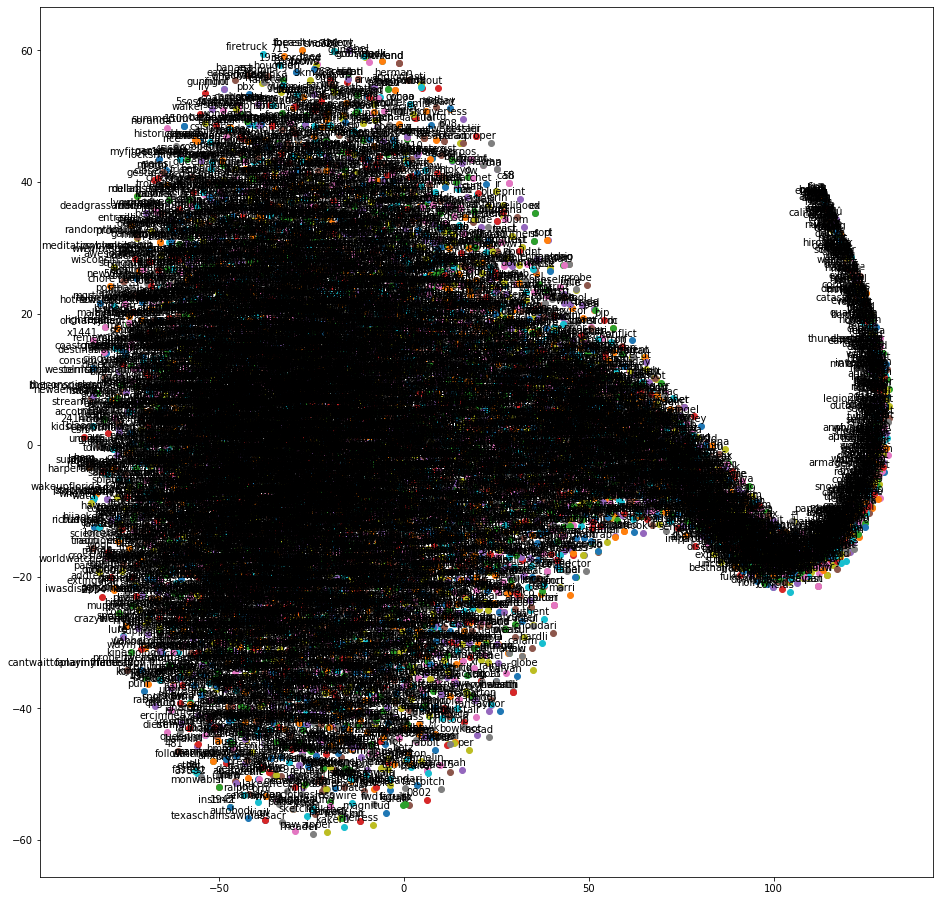

In [825]:
tsne_plot(model1)

In [ ]:
# https://www.kaggle.com/philculliton/nlp-getting-started-tutorial
# Logistic regression with LSA
# Implement GPT-2 Model (https://www.kaggle.com/c/nlp-getting-started/discussion/130823)
# https://www.kaggle.com/rahulvks/text-rank-sub-keyword-analysis-nlu